# CRISP-DM Bullshit here

### Import librairies

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functions import *
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from pydotplus import graph_from_dot_data
from xgboost import XGBClassifier
from pprint import pprint
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

%matplotlib inline

### Read csv file and preview file

In [2]:
df = pd.read_csv("Poker.csv", encoding='latin-1')
df.head(2)

,Player Name,Site,Hands,Net Won,VP$IP,PFR,3Bet,Postflop Agg%,W$WSF%,WTSD%,...,Raise River CBet,Squeeze,Raise Two Raisers,Call Two Raisers,vs 3Bet Fold,vs 3Bet Call,vs 3Bet Raise,vs 4Bet Fold,vs 4Bet Call,vs 4Bet Raise
0,LocSta,22,2035485,128473.89,0.249043,0.210084,0.094206,0.351073,0.477881,0.293348,...,0.113415,0.102155,0.040503,0.016301,0.604096,0.242094,0.154423,0.354854,0.284278,0.360868
1,.PARTOUCHE.,22,178311,15940.79,0.251039,0.201261,0.077332,0.314294,0.422270,0.242501,...,0.135371,0.076993,0.026232,0.010154,0.679106,0.209865,0.112322,0.481436,0.191832,0.326733


In [3]:
print("Before filtering")
winners = len(df[df["Net Won"] > 0])
losers = len(df[df["Net Won"] <= 0])
print(winners, "winners")
print(losers, "losers")
print("Winners %", winners / (winners + losers))

Before filtering
3085 winners
5737 losers
Winners % 0.3496939469508048


### If we want to use only the players with a minimum number of hands uncomment the cell below

In [4]:
# df = df[df['Hands'] > 500]

In [5]:
pprint(list(df.columns))

['Player Name',
 'Site',
 'Hands',
 'Net Won',
 'VP$IP',
 'PFR',
 '3Bet',
 'Postflop\nAgg%',
 'W$WSF%',
 'WTSD%',
 'Won $\nat SD',
 'Flop\nCBet%',
 'Turn\nCBet%',
 'River\nCBet%',
 'Fold to\nFlop Cbet',
 'Fold to\nTurn CBet',
 'Fold to\nRiver CBet',
 'Raise\nFlop Cbet',
 'Raise\nTurn CBet',
 'Raise\nRiver CBet',
 'Squeeze',
 'Raise Two\nRaisers',
 'Call Two\nRaisers',
 'vs 3Bet\nFold',
 'vs 3Bet\nCall',
 'vs 3Bet\nRaise',
 'vs 4Bet\nFold',
 'vs 4Bet\nCall',
 'vs 4Bet\nRaise']


### Rename columns for more clarity (replacing \n by spaces)

In [6]:
df.columns = df.columns.str.replace('\n',' ')
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns

In [7]:
df.head(2)

,Player_Name,Site,Hands,Net_Won,VP$IP,PFR,3Bet,Postflop_Agg%,W$WSF%,WTSD%,...,Raise_River_CBet,Squeeze,Raise_Two_Raisers,Call_Two_Raisers,vs_3Bet_Fold,vs_3Bet_Call,vs_3Bet_Raise,vs_4Bet_Fold,vs_4Bet_Call,vs_4Bet_Raise
0,LocSta,22,2035485,128473.89,0.249043,0.210084,0.094206,0.351073,0.477881,0.293348,...,0.113415,0.102155,0.040503,0.016301,0.604096,0.242094,0.154423,0.354854,0.284278,0.360868
1,.PARTOUCHE.,22,178311,15940.79,0.251039,0.201261,0.077332,0.314294,0.422270,0.242501,...,0.135371,0.076993,0.026232,0.010154,0.679106,0.209865,0.112322,0.481436,0.191832,0.326733


### Build the target based on Net Won vs Hands Played

In [8]:
df["target"] = df["Net_Won"] > 0

### Drop useless columns

In [9]:
df.drop(['Player_Name', 'Site', "Hands", "Net_Won"], axis=1, inplace=True)

## Pre-processing data

#### Check data types

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8822 entries, 0 to 8821
Data columns (total 26 columns):
VP$IP                 8822 non-null float64
PFR                   8822 non-null float64
3Bet                  8822 non-null float64
Postflop_Agg%         8822 non-null float64
W$WSF%                8822 non-null float64
WTSD%                 8822 non-null float64
Won_$_at_SD           8822 non-null float64
Flop_CBet%            8822 non-null float64
Turn_CBet%            8822 non-null float64
River_CBet%           8822 non-null float64
Fold_to_Flop_Cbet     8822 non-null float64
Fold_to_Turn_CBet     8822 non-null float64
Fold_to_River_CBet    8822 non-null float64
Raise_Flop_Cbet       8822 non-null float64
Raise_Turn_CBet       8822 non-null float64
Raise_River_CBet      8822 non-null float64
Squeeze               8822 non-null float64
Raise_Two_Raisers     8822 non-null float64
Call_Two_Raisers      8822 non-null float64
vs_3Bet_Fold          8822 non-null float64
vs_3Bet_Call 

All our predictors are floats (percentages), there are no missing values and our target is a boolean

#TODO: Check for number of unique values in the last 15 columns and maybe drop the ones that don't have a lot of different values meaning there were not enough occurences

### Check for class imbalance

In [11]:
winners = len(df[df["target"] == True])
losers = len(df[df["target"] == False])
print(winners, "winners")
print(losers, "losers")
print("Winners %", winners / (winners + losers))
print("Losers %", 1 - (winners / (winners + losers)))

3085 winners
5737 losers
Winners % 0.3496939469508048
Losers % 0.6503060530491952


The class imbalance isn't very strong, therefore we can move on with this data

### Because we don't have too many dimensions, instead of using Principal Component Analysis we will check for multicollinearities over 70 percents using our homemade function

### Check multicollinearities

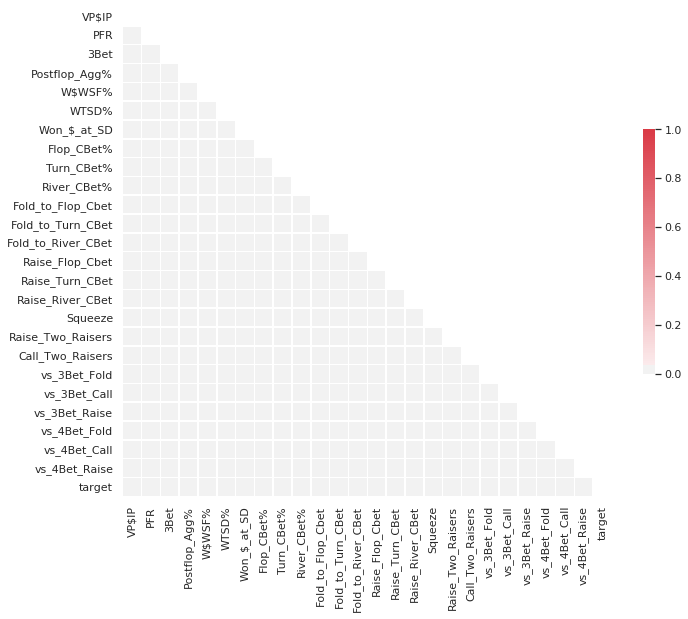

In [12]:
print_corr(df, pct=0.75)

None of our features have more than 70 percent multicollinearities

### Split the data between train and test datasets

In [13]:
labels = df["target"]
df = df.drop(["target"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.20, random_state=42)
X_train = X_train.reset_index().drop(["index"], axis=1)
y_train = y_train.reset_index().drop(["index"], axis=1)
X_test = X_test.reset_index().drop(["index"], axis=1)
y_test = y_test.reset_index().drop(["index"], axis=1)

## Baseline classifier using Logistic Regression

We are going to build a Logistic Regression model using a 5 fold cross validation as our baseline model

# TODO: Fix this and Define a threshold

In [14]:
# Logistic Regression Cross Validation
baseline = LogisticRegressionCV(random_state=42, cv=5)

# Fit the pipelines
baseline.fit(X_train, y_train.values.ravel())

# print(np.sum(baseline.predict(X_test) == y_test)/len(y_test))
preds = np.array(baseline.predict_proba(X_train)).reshape(-1, 1)

baseline_score = baseline.score(X_train, y_train.values.ravel())
print("Our baseline model average accuracy score is", round(baseline_score, 4), "\n")

#Print ROC Curve
# lr_roc(y_train, preds, plot=True)

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Our baseline model average accuracy score is 0.7527 



# Feature Engineering

## Interactions

In [15]:
df.columns

Index(['VP$IP', 'PFR', '3Bet', 'Postflop_Agg%', 'W$WSF%', 'WTSD%',
       'Won_$_at_SD', 'Flop_CBet%', 'Turn_CBet%', 'River_CBet%',
       'Fold_to_Flop_Cbet', 'Fold_to_Turn_CBet', 'Fold_to_River_CBet',
       'Raise_Flop_Cbet', 'Raise_Turn_CBet', 'Raise_River_CBet', 'Squeeze',
       'Raise_Two_Raisers', 'Call_Two_Raisers', 'vs_3Bet_Fold', 'vs_3Bet_Call',
       'vs_3Bet_Raise', 'vs_4Bet_Fold', 'vs_4Bet_Call', 'vs_4Bet_Raise'],
      dtype='object')

In [16]:
combinations = list(combinations(list(X_train.columns), 2))
interactions = []
data = X_train.copy()
for comb in combinations:
    regression = LogisticRegressionCV(random_state=42, cv=5)
    data['interaction'] = data[comb[0]] * data[comb[1]]
    regression.fit(data, y_train.values.ravel())
    score = regression.score(data, y_train)
    if score > baseline_score: interactions.append((comb[0], comb[1], round(score, 3)))
    data.drop(["interaction"], axis=1, inplace=True)
            
print('Top 10 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:10])

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

Top 10 interactions: [('VP$IP', 'River_CBet%', 0.755), ('WTSD%', 'Won_$_at_SD', 0.755), ('Won_$_at_SD', 'Fold_to_River_CBet', 0.755), ('VP$IP', 'Fold_to_Turn_CBet', 0.754), ('PFR', 'W$WSF%', 0.754), ('PFR', 'Won_$_at_SD', 0.754), ('PFR', 'Fold_to_River_CBet', 0.754), ('PFR', 'vs_3Bet_Fold', 0.754), ('3Bet', 'vs_3Bet_Fold', 0.754), ('Postflop_Agg%', 'Flop_CBet%', 0.754)]


Adding top 10 interactions to the datasets

In [17]:
for dataset in [X_train, X_test]:
    for interaction in interactions[:10]:
        col1 = interaction[0]
        col2 = interaction[1]
        colname = str(col1) + "_*_" + str(col2)
        dataset[colname] = dataset[col1] * dataset[col2]

In [18]:
X_train.head()

,VP$IP,PFR,3Bet,Postflop_Agg%,W$WSF%,WTSD%,Won_$_at_SD,Flop_CBet%,Turn_CBet%,River_CBet%,...,VP$IP_*_PFR,VP$IP_*_Postflop_Agg%,VP$IP_*_Turn_CBet%,VP$IP_*_River_CBet%,VP$IP_*_Fold_to_Turn_CBet,VP$IP_*_Call_Two_Raisers,VP$IP_*_vs_3Bet_Fold,VP$IP_*_vs_3Bet_Call,VP$IP_*_vs_4Bet_Call,PFR_*_W$WSF%
0,0.217742,0.165323,0.043478,0.339623,0.461538,0.461538,0.583333,0.666667,0.500000,0.000000,...,0.035998,0.073950,0.108871,0.000000,0.000000,0.000000,0.155530,0.031106,0.000000,0.076303
1,0.529730,0.183784,0.026316,0.588710,0.590909,0.181818,0.500000,0.714286,0.000000,0.000000,...,0.097356,0.311857,0.000000,0.000000,0.000000,0.132432,0.132432,0.397297,0.000000,0.108600
2,0.367943,0.149903,0.083039,0.363300,0.553086,0.239506,0.453608,0.850000,0.714286,0.363636,...,0.055156,0.133674,0.262816,0.133797,0.134912,0.000000,0.245295,0.109020,0.147177,0.082909
3,0.260417,0.159722,0.056000,0.345455,0.436364,0.290909,0.437500,0.500000,0.800000,1.000000,...,0.041594,0.089962,0.208333,0.260417,0.000000,0.021701,0.000000,0.227865,0.260417,0.069697
4,0.272482,0.202425,0.080512,0.251121,0.431767,0.259508,0.560345,0.525974,0.321429,0.500000,...,0.055157,0.068426,0.087584,0.136241,0.154407,0.006728,0.110290,0.126510,0.071706,0.087401


## Polynomials

Checking which polynomials have the biggest impact once added to our baseline model

In [19]:
# We'll fit 3 different polynomial regression models from degree 2 to degree 4
columns = list(X_train.columns)
polynomials = []
for col in columns:
    for degree in [2, 3, 4]:
        data = X_train.copy()
        poly = PolynomialFeatures(degree, include_bias=False)
        X_transformed = poly.fit_transform(X_train[[col]])
        data = pd.concat([data.drop(col, axis=1),pd.DataFrame(X_transformed)], axis=1)
        
        #Instantiate and fit a cross validation logistic regression model to the polynomial transformed train features
        lr = LogisticRegressionCV(random_state=42, cv=5)
        lr.fit(data, y_train.values.ravel())
        
        #Build 
        score = lr.score(data, y_train)
        if score > baseline_score: polynomials.append((col, degree, round(score, 5)))

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: Converge

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: Converge

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: Converge

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: Converge

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: Converge

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: Converge

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: Converge

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

Top 10 polynomials: [('Won_$_at_SD', 3, 0.7557), ('Postflop_Agg%', 4, 0.755), ('Won_$_at_SD', 2, 0.755), ('Fold_to_Turn_CBet', 4, 0.755), ('Won_$_at_SD', 4, 0.75485), ('Fold_to_Turn_CBet', 3, 0.75471), ('Raise_Turn_CBet', 2, 0.75471), ('Raise_Turn_CBet', 3, 0.75471), ('Turn_CBet%', 2, 0.75457), ('Turn_CBet%', 4, 0.75457)]


Listing the top 10 polynomials into a dictionnary

In [86]:
polynomials = sorted(polynomials, key=lambda poly: poly[2], reverse=True)

[('Won_$_at_SD', 3, 0.7557),
 ('Postflop_Agg%', 4, 0.755),
 ('Won_$_at_SD', 2, 0.755),
 ('Fold_to_Turn_CBet', 4, 0.755),
 ('Won_$_at_SD', 4, 0.75485)]


In [21]:
polynomials_to_add = {}
for pol in polynomials:
    if pol[0] not in polynomials_to_add.keys():
        polynomials_to_add[pol[0]] = pol[1]
    if len(polynomials_to_add) == 10:
        break

In [22]:
pprint(polynomials_to_add)

{'Flop_CBet%': 3,
 'Fold_to_Flop_Cbet': 3,
 'Fold_to_Turn_CBet': 4,
 'Postflop_Agg%': 4,
 'Raise_River_CBet': 3,
 'Raise_Turn_CBet': 2,
 'Squeeze': 4,
 'Turn_CBet%': 2,
 'VP$IP': 3,
 'Won_$_at_SD': 3}


Adding top 10 polynomials to X_train and X_test datasets

In [23]:
X_ = X_train.copy()
X_t = X_test.copy()
for col, degree in polynomials_to_add.items():
    #Instantiate PolynomialFeatures
    poly = PolynomialFeatures(degree, include_bias=False)
    #Fit and transform X_train
    X_poly_train = poly.fit_transform(np.array(X_[col]).reshape(-1, 1))
    X_poly_test = poly.transform(np.array(X_t[col]).reshape(-1, 1))
    #List column names including the original column
    colnames = [col]
    #Append polynomial columns names to list of columns names
    for deg in range(2, degree+1):
        colnames.append(str(col + "_^" + str(deg)))
    #Add polynomial columns to train and test data sets
    X_train = pd.concat([X_train.drop(col, axis=1),pd.DataFrame(X_poly_train, columns=colnames)], axis=1)
    X_test = pd.concat([X_test.drop(col, axis=1),pd.DataFrame(X_poly_test, columns=colnames)], axis=1)

In [24]:
X_train.head()

,PFR,3Bet,W$WSF%,WTSD%,River_CBet%,Fold_to_River_CBet,Raise_Flop_Cbet,Raise_Two_Raisers,Call_Two_Raisers,vs_3Bet_Fold,...,Flop_CBet%,Flop_CBet%_^2,Flop_CBet%_^3,Fold_to_Flop_Cbet,Fold_to_Flop_Cbet_^2,Fold_to_Flop_Cbet_^3,Squeeze,Squeeze_^2,Squeeze_^3,Squeeze_^4
0,0.165323,0.043478,0.461538,0.461538,0.000000,0.000000,0.285714,0.000000,0.000000,0.714286,...,0.666667,0.444444,0.296296,0.285714,0.081633,0.023324,0.058824,0.003460,0.000204,1.197303e-05
1,0.183784,0.026316,0.590909,0.181818,0.000000,0.000000,0.166667,0.000000,0.250000,0.250000,...,0.714286,0.510204,0.364431,0.750000,0.562500,0.421875,0.000000,0.000000,0.000000,0.000000e+00
2,0.149903,0.083039,0.553086,0.239506,0.363636,0.250000,0.056604,0.023256,0.000000,0.666667,...,0.850000,0.722500,0.614125,0.452830,0.205055,0.092855,0.037736,0.001424,0.000054,2.027760e-06
3,0.159722,0.056000,0.436364,0.290909,1.000000,0.000000,0.192308,0.000000,0.083333,0.000000,...,0.500000,0.250000,0.125000,0.538462,0.289941,0.156122,0.166667,0.027778,0.004630,7.716047e-04
4,0.202425,0.080512,0.431767,0.259508,0.500000,0.571428,0.064516,0.024691,0.024691,0.404762,...,0.525974,0.276649,0.145510,0.535484,0.286743,0.153546,0.024793,0.000615,0.000015,3.778710e-07


### Export X_train, X_test, y_train and y_test

In [35]:
X_train.to_csv('Datasets/X_train.csv', index = None, header=True)
X_test.to_csv('Datasets/X_test.csv', index = None, header=True)
y_train.to_csv('Datasets/y_train.csv', index = None, header=True)
y_test.to_csv('Datasets/y_test.csv', index = None, header=True)

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [26]:
ls

functions.py     marc_index.ipynb  __pycache__/  X_test.csv   y_test.csv
joe_index.ipynb  Poker.csv         README.md     X_train.csv  y_train.csv


### Import X_train, X_test, y_train and y_test

In [53]:
X_train = pd.read_csv("Datasets/X_train.csv")
X_test = pd.read_csv("Datasets/X_test.csv")
y_train = pd.read_csv("Datasets/y_train.csv")
y_test = pd.read_csv("Datasets/y_test.csv")
X_train.head()

,PFR,3Bet,W$WSF%,WTSD%,River_CBet%,Fold_to_River_CBet,Raise_Flop_Cbet,Raise_Two_Raisers,Call_Two_Raisers,vs_3Bet_Fold,...,Flop_CBet%,Flop_CBet%_^2,Flop_CBet%_^3,Fold_to_Flop_Cbet,Fold_to_Flop_Cbet_^2,Fold_to_Flop_Cbet_^3,Squeeze,Squeeze_^2,Squeeze_^3,Squeeze_^4
0,0.165323,0.043478,0.461538,0.461538,0.000000,0.000000,0.285714,0.000000,0.000000,0.714286,...,0.666667,0.444444,0.296296,0.285714,0.081633,0.023324,0.058824,0.003460,0.000204,1.197303e-05
1,0.183784,0.026316,0.590909,0.181818,0.000000,0.000000,0.166667,0.000000,0.250000,0.250000,...,0.714286,0.510204,0.364431,0.750000,0.562500,0.421875,0.000000,0.000000,0.000000,0.000000e+00
2,0.149903,0.083039,0.553086,0.239506,0.363636,0.250000,0.056604,0.023256,0.000000,0.666667,...,0.850000,0.722500,0.614125,0.452830,0.205055,0.092855,0.037736,0.001424,0.000054,2.027760e-06
3,0.159722,0.056000,0.436364,0.290909,1.000000,0.000000,0.192308,0.000000,0.083333,0.000000,...,0.500000,0.250000,0.125000,0.538462,0.289941,0.156122,0.166667,0.027778,0.004630,7.716047e-04
4,0.202425,0.080512,0.431767,0.259508,0.500000,0.571428,0.064516,0.024691,0.024691,0.404762,...,0.525974,0.276649,0.145510,0.535484,0.286743,0.153546,0.024793,0.000615,0.000015,3.778710e-07


## Build pipelines

In [55]:
# Defining pipelines
pipe_knn = Pipeline([('mms', MinMaxScaler()),('knn', KNeighborsClassifier(n_neighbors=11))])
pipe_svm = Pipeline([('mms', MinMaxScaler()),('svm', SVC(random_state=123))])
pipe_tree = Pipeline([('mms', MinMaxScaler()),('tree', DecisionTreeClassifier(max_depth=6, random_state=123))])
pipe_rf = Pipeline([('mms', MinMaxScaler()),('rf', RandomForestClassifier(max_depth=6, random_state=123))])

# List of pipelines, List of pipeline names
pipelines = [pipe_knn, pipe_svm, pipe_tree, pipe_rf]
pipeline_names = ['K-Nearest Neighbors','Support Vector Machine','Decision Tree','Random Forest']

# Fit the different models
for pipe in pipelines:
    pipe.fit(X_train, y_train.values.ravel())
    
# Compare accuracies
for index, val in enumerate(pipelines):
    print('%s pipeline accuracy: %.3f' % (pipeline_names[index], val.score(X_train, y_train)))

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


K-Nearest Neighbors pipeline accuracy: 0.742
Support Vector Machine pipeline accuracy: 0.730
Decision Tree pipeline accuracy: 0.781
Random Forest pipeline accuracy: 0.783


## K-Nearest-Neighbors Pipeline with Grid Search

In [85]:
# Construct pipeline
pipe_knn = Pipeline([('mms', MinMaxScaler()),('knn', KNeighborsClassifier())])

# Set grid search params
param_grid_knn = [
    {'knn__n_neighbors': list(range(1,51))}
]

print(pipe_knn.get_params().keys())
# Construct grid search
gs_knn = GridSearchCV(estimator=pipe_knn, param_grid=param_grid_knn, scoring='roc_auc', cv=3, n_jobs=-1)

# Fit using grid search
gs_knn.fit(X_train, y_train.values.ravel())

# Best accuracy
print('Best f1: %.3f' % gs_knn.best_score_)

# Best params
print('\nBest params:\n', gs_knn.best_params_)

dict_keys(['memory', 'steps', 'verbose', 'mms', 'knn', 'mms__copy', 'mms__feature_range', 'knn__algorithm', 'knn__leaf_size', 'knn__metric', 'knn__metric_params', 'knn__n_jobs', 'knn__n_neighbors', 'knn__p', 'knn__weights'])
Best f1: 0.708

Best params:
 {'knn__n_neighbors': 49}


## Random Forest Classifier Pipeline with Grid Search

In [83]:
# Construct pipeline
pipe_rf = Pipeline([('mms', MinMaxScaler()),('rf', RandomForestClassifier(random_state=123))])

# Set grid search params
param_grid_forest = [
    {'rf__n_estimators': [10, 20],
     'rf__criterion': ['entropy', 'gini'],
     'rf__max_depth': [4, 5, 6],
     'rf__max_features': [35, 45]
#      'rf__min_samples_leaf':[0.05 ,0.1, 0.2],
#      'rf__samples_split':[0.05 ,0.1, 0.2]
    }
]

print(pipe_rf.get_params().keys())

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf, param_grid=param_grid_forest, scoring='roc_auc', cv=3, verbose=2, return_train_score=True)

# # Fit using grid search
gs_rf.fit(X_train, y_train.values.ravel())

# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

dict_keys(['memory', 'steps', 'verbose', 'mms', 'rf', 'mms__copy', 'mms__feature_range', 'rf__bootstrap', 'rf__class_weight', 'rf__criterion', 'rf__max_depth', 'rf__max_features', 'rf__max_leaf_nodes', 'rf__min_impurity_decrease', 'rf__min_impurity_split', 'rf__min_samples_leaf', 'rf__min_samples_split', 'rf__min_weight_fraction_leaf', 'rf__n_estimators', 'rf__n_jobs', 'rf__oob_score', 'rf__random_state', 'rf__verbose', 'rf__warm_start'])
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] rf__criterion=entropy, rf__max_depth=4, rf__max_features=35, rf__n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rf__criterion=entropy, rf__max_depth=4, rf__max_features=35, rf__n_estimators=10, total=   0.4s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__max_features=35, rf__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  rf__criterion=entropy, rf__max_depth=4, rf__max_features=35, rf__n_estimators=10, total=   0.3s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__max_features=35, rf__n_estimators=10 
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__max_features=35, rf__n_estimators=10, total=   0.3s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__max_features=35, rf__n_estimators=20 
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__max_features=35, rf__n_estimators=20, total=   0.7s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__max_features=35, rf__n_estimators=20 
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__max_features=35, rf__n_estimators=20, total=   0.6s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__max_features=35, rf__n_estimators=20 
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__max_features=35, rf__n_estimators=20, total=   0.6s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__max_features=45, rf__n_estimators=10 
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__max_f

KeyboardInterrupt: 

In [61]:
pprint(list(pipe_rf.get_params().keys()))

['memory',
 'steps',
 'verbose',
 'mms',
 'rf',
 'mms__copy',
 'mms__feature_range',
 'rf__bootstrap',
 'rf__class_weight',
 'rf__criterion',
 'rf__max_depth',
 'rf__max_features',
 'rf__max_leaf_nodes',
 'rf__min_impurity_decrease',
 'rf__min_impurity_split',
 'rf__min_samples_leaf',
 'rf__min_samples_split',
 'rf__min_weight_fraction_leaf',
 'rf__n_estimators',
 'rf__n_jobs',
 'rf__oob_score',
 'rf__random_state',
 'rf__verbose',
 'rf__warm_start']


## XGBoost Classifier Pipeline with Grid Search

In [70]:
# Construct pipeline
pipe_xgb = Pipeline([('mms', MinMaxScaler()),('xgb', XGBClassifier(random_state=123))])

# Set grid search params
param_grid_xgb = {
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5]
}

# Construct grid search
gs_xgb = GridSearchCV(estimator=pipe_xgb, param_grid=param_grid_xgb, scoring='roc_auc', cv=3, verbose=2, return_train_score=True)

# Fit using grid search
gs_xgb.fit(X_train, y_train.values.ravel())

# Best accuracy
print('Best accuracy: %.3f' % gs_xgb.best_score_)

# Best params
print('\nBest params:\n', gs_xgb.best_params_)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
[CV] xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.6, total=   0.7s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.6, total=   0.7s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.6, total=   0.7s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.8, total=   0.7s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.8, total=   0.6s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb

[CV]  xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.6, total=   0.9s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.6, total=   0.9s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.6, total=   1.0s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.8, total=   1.0s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb

[CV]  xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=1.0, total=   1.1s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6, total=   1.1s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6, total=   1.2s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6, total=   1.1s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=0

[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=1.0, total=   0.7s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=1.0, total=   0.8s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.6, total=   1.3s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.6, total=   1.0s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=4, 

[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=1.0, total=   1.0s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=1.0, total=   1.0s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.6, total=   1.1s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.6, total=   1.2s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1, xgb__max_depth=5, xgb

[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=1.0, total=   0.7s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=1.0, total=   0.7s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=1.0, total=   0.7s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.6, total=   0.8s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1.5, 

[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1.5, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.8, total=   0.9s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=1.5, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1.5, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=1.0, total=   1.1s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=1.5, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1.5, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=1.0, total=   0.8s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=1.5, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1.5, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=1.0, total=   0.8s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=1

[CV]  xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.8, total=   0.7s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.8, total=   0.7s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=1.0, total=   0.7s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=1.0, total=   0.8s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=3, xgb

[CV]  xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.8, total=   0.8s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.8, total=   0.9s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=1.0, total=   0.9s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=1.0, total=   0.9s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=4, xgb

[CV]  xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.8, total=   1.1s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.8, total=   1.1s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=1.0, total=   1.1s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=1.0, total=   1.1s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=2, xgb__max_dept

[CV]  xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.8, total=   1.0s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.8, total=   0.9s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=1.0, total=   0.8s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=1.0, total=   0.8s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=4, xgb

[CV]  xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.8, total=   1.2s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.8, total=   1.2s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=1.0, total=   1.1s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=1.0, total=   1.3s
[CV] xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.6, xgb__gamma=5, xgb__max_depth=5, xgb

[CV]  xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.8, total=   0.8s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.8, total=   0.9s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.8, total=   0.9s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=1.0, total=   0.8s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=

[CV]  xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.6, total=   1.7s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.8, total=   1.9s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.8, total=   1.6s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.8, total=   1.6s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=0.5, xgb

[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.6, total=   0.9s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.6, total=   1.0s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.8, total=   0.8s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.8, total=   1.0s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=3, xgb

[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.6, total=   1.2s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.6, total=   1.6s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.8, total=   1.8s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.8, total=   1.2s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1, xgb__max_dept

[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.6, total=   0.9s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.6, total=   0.9s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.8, total=   0.8s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.8, total=   0.9s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb

[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.6, total=   1.1s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.6, total=   1.1s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.6, total=   1.3s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.8, total=   1.3s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb

[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=1.0, total=   1.4s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6, total=   1.4s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6, total=   1.5s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6, total=   1.4s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=1

[CV]  xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=1.0, total=   0.8s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=1.0, total=   0.9s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.6, total=   1.3s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.6, total=   1.1s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=4, 

[CV]  xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=1.0, total=   1.4s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=1.0, total=   1.3s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.6, total=   1.4s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.6, total=   1.5s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=2, xgb__max_depth=5, xgb

[CV]  xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=1.0, total=   0.9s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=1.0, total=   0.9s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.6, total=   0.9s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.6, total=   1.3s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=3

[CV]  xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=1.0, total=   1.0s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=1.0, total=   1.1s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.6, total=   1.4s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.6, total=   1.7s
[CV] xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.8, xgb__gamma=5, xgb__max_depth=5, 

[CV]  xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=1.0, total=   1.1s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=1.0, total=   1.0s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=1.0, total=   0.9s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.6, total=   1.1s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb

[CV]  xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.8, total=   1.4s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=1.0, total=   1.3s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=1.0, total=   1.2s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=1.0, total=   1.3s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=0.5, xg

[CV]  xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.8, total=   1.7s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.8, total=   1.7s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=1.0, total=   1.5s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=1.0, total=   1.7s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=0.5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=

[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.8, total=   1.4s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.8, total=   1.4s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=0.8, total=   1.4s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=1.0, total=   1.4s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=4, xgb

[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.8, total=   2.0s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.8, total=   1.7s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=0.8, total=   1.8s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=1.0, total=   1.8s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=5, xgb__min_child_weight=5, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__max_depth=5, xgb

[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.6, total=   1.1s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.8, total=   1.0s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.8, total=   1.0s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=0.8, total=   1.0s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb__max_depth=3, xgb__min_child_weight=10, xgb__subsample=1.0 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=

[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.6, total=   1.7s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.6, total=   1.6s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.8, total=   1.8s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.8, total=   1.8s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=1.5, xgb

[CV]  xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.6, total=   1.1s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.6, total=   1.2s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.6, total=   1.2s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.8, total=   1.0s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=3, xgb__min_child_weight=5, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=3, xgb

[CV]  xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.6, total=   1.3s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.6, total=   1.3s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.6, total=   1.4s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.8, total=   1.3s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=4, xgb__min_child_weight=10, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_dept

[CV]  xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.6, total=   1.1s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.6, total=   1.2s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.6, total=   1.4s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.8, total=   1.1s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=3, xgb__min_child_weight=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=3, xgb

[CV]  xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.6, total=   1.5s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.6, total=   1.4s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.6, total=   1.8s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.8, total=   1.9s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=4, xgb__min_child_weight=5, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=4, xgb

[CV]  xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6, total=   1.7s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6, total=   1.7s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.6, total=   1.7s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.8, total=   1.7s
[CV] xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_depth=5, xgb__min_child_weight=10, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=1.0, xgb__gamma=5, xgb__max_dept

[Parallel(n_jobs=1)]: Done 1215 out of 1215 | elapsed: 24.6min finished


Best accuracy: 0.758

Best params:
 {'xgb__colsample_bytree': 0.6, 'xgb__gamma': 1.5, 'xgb__max_depth': 3, 'xgb__min_child_weight': 10, 'xgb__subsample': 0.8}


Best accuracy: 0.758

Best params:
 {'xgb__colsample_bytree': 0.6, 'xgb__gamma': 1.5, 'xgb__max_depth': 3, 'xgb__min_child_weight': 10, 'xgb__subsample': 0.8}

## Run K-means Clustering

# Conclusions